In [7]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from utils.vqVAE import VQVAE
# from uils.vqVAE_custom import VQVAE

from utils.training import *

## Preparing Dataset 

In [4]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [5]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")



In [6]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)



## Prepairing the model

In [7]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 
downsampling_factor = 8

In [8]:
ACDC_VQVAE = VQVAE(in_channels, D, K, downsampling_factor)


## Training the Model

In [9]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [10]:
### Learning parameters

model = ACDC_VQVAE.to(device)

lr = 5e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models/vqvae_105_bestmodel.pth'

In [11]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [13]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, dice_loss, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

100%|██████████| 119/119 [00:06<00:00, 18.00batch/s, loss=1.28e+4]


Epoch 0: Train Loss: 47616.7135


100%|██████████| 119/119 [00:06<00:00, 17.36batch/s, loss=3.27e+3]


Epoch 1: Train Loss: 35702.2709


100%|██████████| 119/119 [00:06<00:00, 18.04batch/s, loss=1.67e+3]


Epoch 2: Train Loss: 1764.8176


100%|██████████| 119/119 [00:06<00:00, 18.07batch/s, loss=1.18]  


Epoch 3: Train Loss: 343.1962


100%|██████████| 119/119 [00:06<00:00, 17.60batch/s, loss=0.441]


Epoch 4: Train Loss: 0.5367


100%|██████████| 119/119 [00:06<00:00, 17.98batch/s, loss=0.5]  


Epoch 5: Train Loss: 0.4335


100%|██████████| 119/119 [00:06<00:00, 18.37batch/s, loss=0.516]


Epoch 6: Train Loss: 0.3412


100%|██████████| 119/119 [00:06<00:00, 18.24batch/s, loss=0.251]


Epoch 7: Train Loss: 0.2729


100%|██████████| 119/119 [00:06<00:00, 17.87batch/s, loss=0.265]


Epoch 8: Train Loss: 0.2455


100%|██████████| 119/119 [00:06<00:00, 18.91batch/s, loss=0.25] 


Epoch 9: Train Loss: 0.2278


100%|██████████| 119/119 [00:06<00:00, 18.99batch/s, loss=0.172]


Epoch 10: Train Loss: 0.2228


100%|██████████| 119/119 [00:06<00:00, 18.55batch/s, loss=0.185]


Epoch 11: Train Loss: 0.2168


100%|██████████| 119/119 [00:06<00:00, 19.04batch/s, loss=0.196]


Epoch 12: Train Loss: 0.1986


100%|██████████| 119/119 [00:06<00:00, 18.50batch/s, loss=0.227]


Epoch 13: Train Loss: 0.1860


100%|██████████| 119/119 [00:06<00:00, 18.95batch/s, loss=0.175]


Epoch 14: Train Loss: 0.1802


100%|██████████| 119/119 [00:06<00:00, 18.63batch/s, loss=0.247]


Epoch 15: Train Loss: 0.1781


100%|██████████| 119/119 [00:07<00:00, 16.58batch/s, loss=0.214]


Epoch 16: Train Loss: 0.1782


100%|██████████| 119/119 [00:06<00:00, 17.49batch/s, loss=0.153]


Epoch 17: Train Loss: 0.1667


100%|██████████| 119/119 [00:06<00:00, 17.78batch/s, loss=0.117]


Epoch 18: Train Loss: 0.1633


100%|██████████| 119/119 [00:06<00:00, 18.48batch/s, loss=0.193]


Epoch 19: Train Loss: 0.1693


100%|██████████| 119/119 [00:06<00:00, 18.40batch/s, loss=0.195]


Epoch 20: Train Loss: 0.1593


100%|██████████| 119/119 [00:06<00:00, 18.51batch/s, loss=0.15] 


Epoch 21: Train Loss: 0.1656


100%|██████████| 119/119 [00:07<00:00, 16.93batch/s, loss=0.144]


Epoch 22: Train Loss: 0.1580


100%|██████████| 119/119 [00:06<00:00, 18.54batch/s, loss=0.13] 


Epoch 23: Train Loss: 0.1533


100%|██████████| 119/119 [00:06<00:00, 18.37batch/s, loss=0.14] 


Epoch 24: Train Loss: 0.1426


100%|██████████| 119/119 [00:06<00:00, 17.94batch/s, loss=0.123] 


Epoch 25: Train Loss: 0.1280


100%|██████████| 119/119 [00:06<00:00, 17.76batch/s, loss=0.124] 


Epoch 26: Train Loss: 0.1231


100%|██████████| 119/119 [00:06<00:00, 17.32batch/s, loss=0.103] 


Epoch 27: Train Loss: 0.1153


100%|██████████| 119/119 [00:06<00:00, 18.13batch/s, loss=0.109] 


Epoch 28: Train Loss: 0.1132


100%|██████████| 119/119 [00:06<00:00, 18.32batch/s, loss=0.116] 


Epoch 29: Train Loss: 0.1079


100%|██████████| 119/119 [00:06<00:00, 17.36batch/s, loss=0.0846]


Epoch 30: Train Loss: 0.1034


100%|██████████| 119/119 [00:06<00:00, 17.73batch/s, loss=0.0835]


Epoch 31: Train Loss: 0.0924


100%|██████████| 119/119 [00:06<00:00, 17.86batch/s, loss=0.102] 


Epoch 32: Train Loss: 0.0830


100%|██████████| 119/119 [00:06<00:00, 18.57batch/s, loss=0.0784]


Epoch 33: Train Loss: 0.0822


100%|██████████| 119/119 [00:07<00:00, 16.10batch/s, loss=0.0721]


Epoch 34: Train Loss: 0.0770


100%|██████████| 119/119 [00:06<00:00, 18.94batch/s, loss=0.07]  


Epoch 35: Train Loss: 0.0758


100%|██████████| 119/119 [00:06<00:00, 17.69batch/s, loss=0.0683]


Epoch 36: Train Loss: 0.0715


100%|██████████| 119/119 [00:06<00:00, 17.57batch/s, loss=0.0826]


Epoch 37: Train Loss: 0.0700


100%|██████████| 119/119 [00:06<00:00, 17.54batch/s, loss=0.0772]


Epoch 38: Train Loss: 0.0689


100%|██████████| 119/119 [00:06<00:00, 17.89batch/s, loss=0.0608]


Epoch 39: Train Loss: 0.0677


100%|██████████| 119/119 [00:06<00:00, 18.93batch/s, loss=0.0689]


Epoch 40: Train Loss: 0.0648


100%|██████████| 119/119 [00:06<00:00, 18.77batch/s, loss=0.0607]


Epoch 41: Train Loss: 0.0626


100%|██████████| 119/119 [00:06<00:00, 19.24batch/s, loss=0.0589]


Epoch 42: Train Loss: 0.0642


100%|██████████| 119/119 [00:06<00:00, 18.51batch/s, loss=0.0438]


Epoch 43: Train Loss: 0.0633


100%|██████████| 119/119 [00:06<00:00, 19.11batch/s, loss=0.0601]


Epoch 44: Train Loss: 0.0607


100%|██████████| 119/119 [00:06<00:00, 18.51batch/s, loss=0.0634]


Epoch 45: Train Loss: 0.0590


100%|██████████| 119/119 [00:06<00:00, 18.88batch/s, loss=0.0647]


Epoch 46: Train Loss: 0.0580


100%|██████████| 119/119 [00:06<00:00, 18.86batch/s, loss=0.0596]


Epoch 47: Train Loss: 0.0575


100%|██████████| 119/119 [00:06<00:00, 19.35batch/s, loss=0.06]  


Epoch 48: Train Loss: 0.0576


100%|██████████| 119/119 [00:06<00:00, 18.63batch/s, loss=0.0716]


Epoch 49: Train Loss: 0.0590


100%|██████████| 119/119 [00:06<00:00, 19.34batch/s, loss=0.0578]


Epoch 50: Train Loss: 0.0555


100%|██████████| 119/119 [00:06<00:00, 18.72batch/s, loss=0.0546]


Epoch 51: Train Loss: 0.0549


100%|██████████| 119/119 [00:06<00:00, 18.06batch/s, loss=0.0571]


Epoch 52: Train Loss: 0.0549


100%|██████████| 119/119 [00:06<00:00, 18.79batch/s, loss=0.052] 


Epoch 53: Train Loss: 0.0554


100%|██████████| 119/119 [00:06<00:00, 18.68batch/s, loss=0.0575]


Epoch 54: Train Loss: 0.0537


100%|██████████| 119/119 [00:06<00:00, 18.41batch/s, loss=0.0579]


Epoch 55: Train Loss: 0.0530


100%|██████████| 119/119 [00:06<00:00, 19.04batch/s, loss=0.0522]


Epoch 56: Train Loss: 0.0531


100%|██████████| 119/119 [00:06<00:00, 19.28batch/s, loss=0.0454]


Epoch 57: Train Loss: 0.0517


100%|██████████| 119/119 [00:06<00:00, 19.07batch/s, loss=0.0467]


Epoch 58: Train Loss: 0.0526


100%|██████████| 119/119 [00:06<00:00, 19.25batch/s, loss=0.0398]


Epoch 59: Train Loss: 0.0504


100%|██████████| 119/119 [00:06<00:00, 18.54batch/s, loss=0.0465]


Epoch 60: Train Loss: 0.0500


100%|██████████| 119/119 [00:06<00:00, 19.07batch/s, loss=0.453]


Epoch 61: Train Loss: 0.3579


100%|██████████| 119/119 [00:06<00:00, 19.18batch/s, loss=0.0944]


Epoch 62: Train Loss: 0.1681


100%|██████████| 119/119 [00:06<00:00, 19.13batch/s, loss=0.0771]


Epoch 63: Train Loss: 0.0915


100%|██████████| 119/119 [00:06<00:00, 18.92batch/s, loss=0.0561]


Epoch 64: Train Loss: 0.0876


100%|██████████| 119/119 [00:06<00:00, 18.91batch/s, loss=0.0724]


Epoch 65: Train Loss: 0.0671


100%|██████████| 119/119 [00:06<00:00, 19.37batch/s, loss=0.0601]


Epoch 66: Train Loss: 0.0624


100%|██████████| 119/119 [00:06<00:00, 18.55batch/s, loss=0.055] 


Epoch 67: Train Loss: 0.0618


100%|██████████| 119/119 [00:06<00:00, 19.12batch/s, loss=0.0549]


Epoch 68: Train Loss: 0.0551


100%|██████████| 119/119 [00:06<00:00, 18.49batch/s, loss=0.0483]


Epoch 69: Train Loss: 0.0525


100%|██████████| 119/119 [00:06<00:00, 19.25batch/s, loss=0.0609]


Epoch 70: Train Loss: 0.0495


100%|██████████| 119/119 [00:06<00:00, 19.07batch/s, loss=0.044] 


Epoch 71: Train Loss: 0.0510


100%|██████████| 119/119 [00:06<00:00, 18.44batch/s, loss=0.0441]


Epoch 72: Train Loss: 0.0477


100%|██████████| 119/119 [00:06<00:00, 18.76batch/s, loss=0.0437]


Epoch 73: Train Loss: 0.0471


100%|██████████| 119/119 [00:06<00:00, 18.63batch/s, loss=0.0432]


Epoch 74: Train Loss: 0.0470


100%|██████████| 119/119 [00:06<00:00, 19.14batch/s, loss=0.0418]


Epoch 75: Train Loss: 0.0458


100%|██████████| 119/119 [00:06<00:00, 19.04batch/s, loss=0.0392]


Epoch 76: Train Loss: 0.0448


100%|██████████| 119/119 [00:06<00:00, 18.70batch/s, loss=0.0408]


Epoch 77: Train Loss: 0.0438


100%|██████████| 119/119 [00:06<00:00, 18.24batch/s, loss=0.0483]


Epoch 78: Train Loss: 0.0434


100%|██████████| 119/119 [00:06<00:00, 19.09batch/s, loss=0.0438]


Epoch 79: Train Loss: 0.0424


100%|██████████| 119/119 [00:06<00:00, 19.33batch/s, loss=0.0376]


Epoch 80: Train Loss: 0.0425


100%|██████████| 119/119 [00:06<00:00, 19.04batch/s, loss=0.0336]


Epoch 81: Train Loss: 0.0413


100%|██████████| 119/119 [00:06<00:00, 19.32batch/s, loss=0.0437]


Epoch 82: Train Loss: 0.0409


100%|██████████| 119/119 [00:06<00:00, 18.72batch/s, loss=0.0335]


Epoch 83: Train Loss: 0.0406


100%|██████████| 119/119 [00:06<00:00, 18.80batch/s, loss=0.0407]


Epoch 84: Train Loss: 0.0401


100%|██████████| 119/119 [00:06<00:00, 19.05batch/s, loss=0.0396]


Epoch 85: Train Loss: 0.0401


100%|██████████| 119/119 [00:06<00:00, 19.02batch/s, loss=0.0638]


Epoch 86: Train Loss: 0.1098


100%|██████████| 119/119 [00:06<00:00, 18.66batch/s, loss=0.0618]


Epoch 87: Train Loss: 0.0584


100%|██████████| 119/119 [00:06<00:00, 19.00batch/s, loss=0.0518]


Epoch 88: Train Loss: 0.0486


100%|██████████| 119/119 [00:06<00:00, 19.55batch/s, loss=0.0408]


Epoch 89: Train Loss: 0.0422


100%|██████████| 119/119 [00:06<00:00, 18.88batch/s, loss=0.0374]


Epoch 90: Train Loss: 0.0391


100%|██████████| 119/119 [00:06<00:00, 18.66batch/s, loss=0.0365]


Epoch 91: Train Loss: 0.0376


100%|██████████| 119/119 [00:06<00:00, 17.61batch/s, loss=0.0422]


Epoch 92: Train Loss: 0.0363


100%|██████████| 119/119 [00:06<00:00, 17.75batch/s, loss=0.0364]


Epoch 93: Train Loss: 0.0350


100%|██████████| 119/119 [00:06<00:00, 18.77batch/s, loss=0.029] 


Epoch 94: Train Loss: 0.0342


100%|██████████| 119/119 [00:06<00:00, 18.67batch/s, loss=0.0386]


Epoch 95: Train Loss: 0.0336


100%|██████████| 119/119 [00:06<00:00, 19.39batch/s, loss=0.0372]


Epoch 96: Train Loss: 0.0329


100%|██████████| 119/119 [00:06<00:00, 18.76batch/s, loss=0.0327]


Epoch 97: Train Loss: 0.0333


100%|██████████| 119/119 [00:06<00:00, 18.29batch/s, loss=0.0303]


Epoch 98: Train Loss: 0.0320


100%|██████████| 119/119 [00:07<00:00, 16.89batch/s, loss=0.031] 


Epoch 99: Train Loss: 0.0313
Training complete.


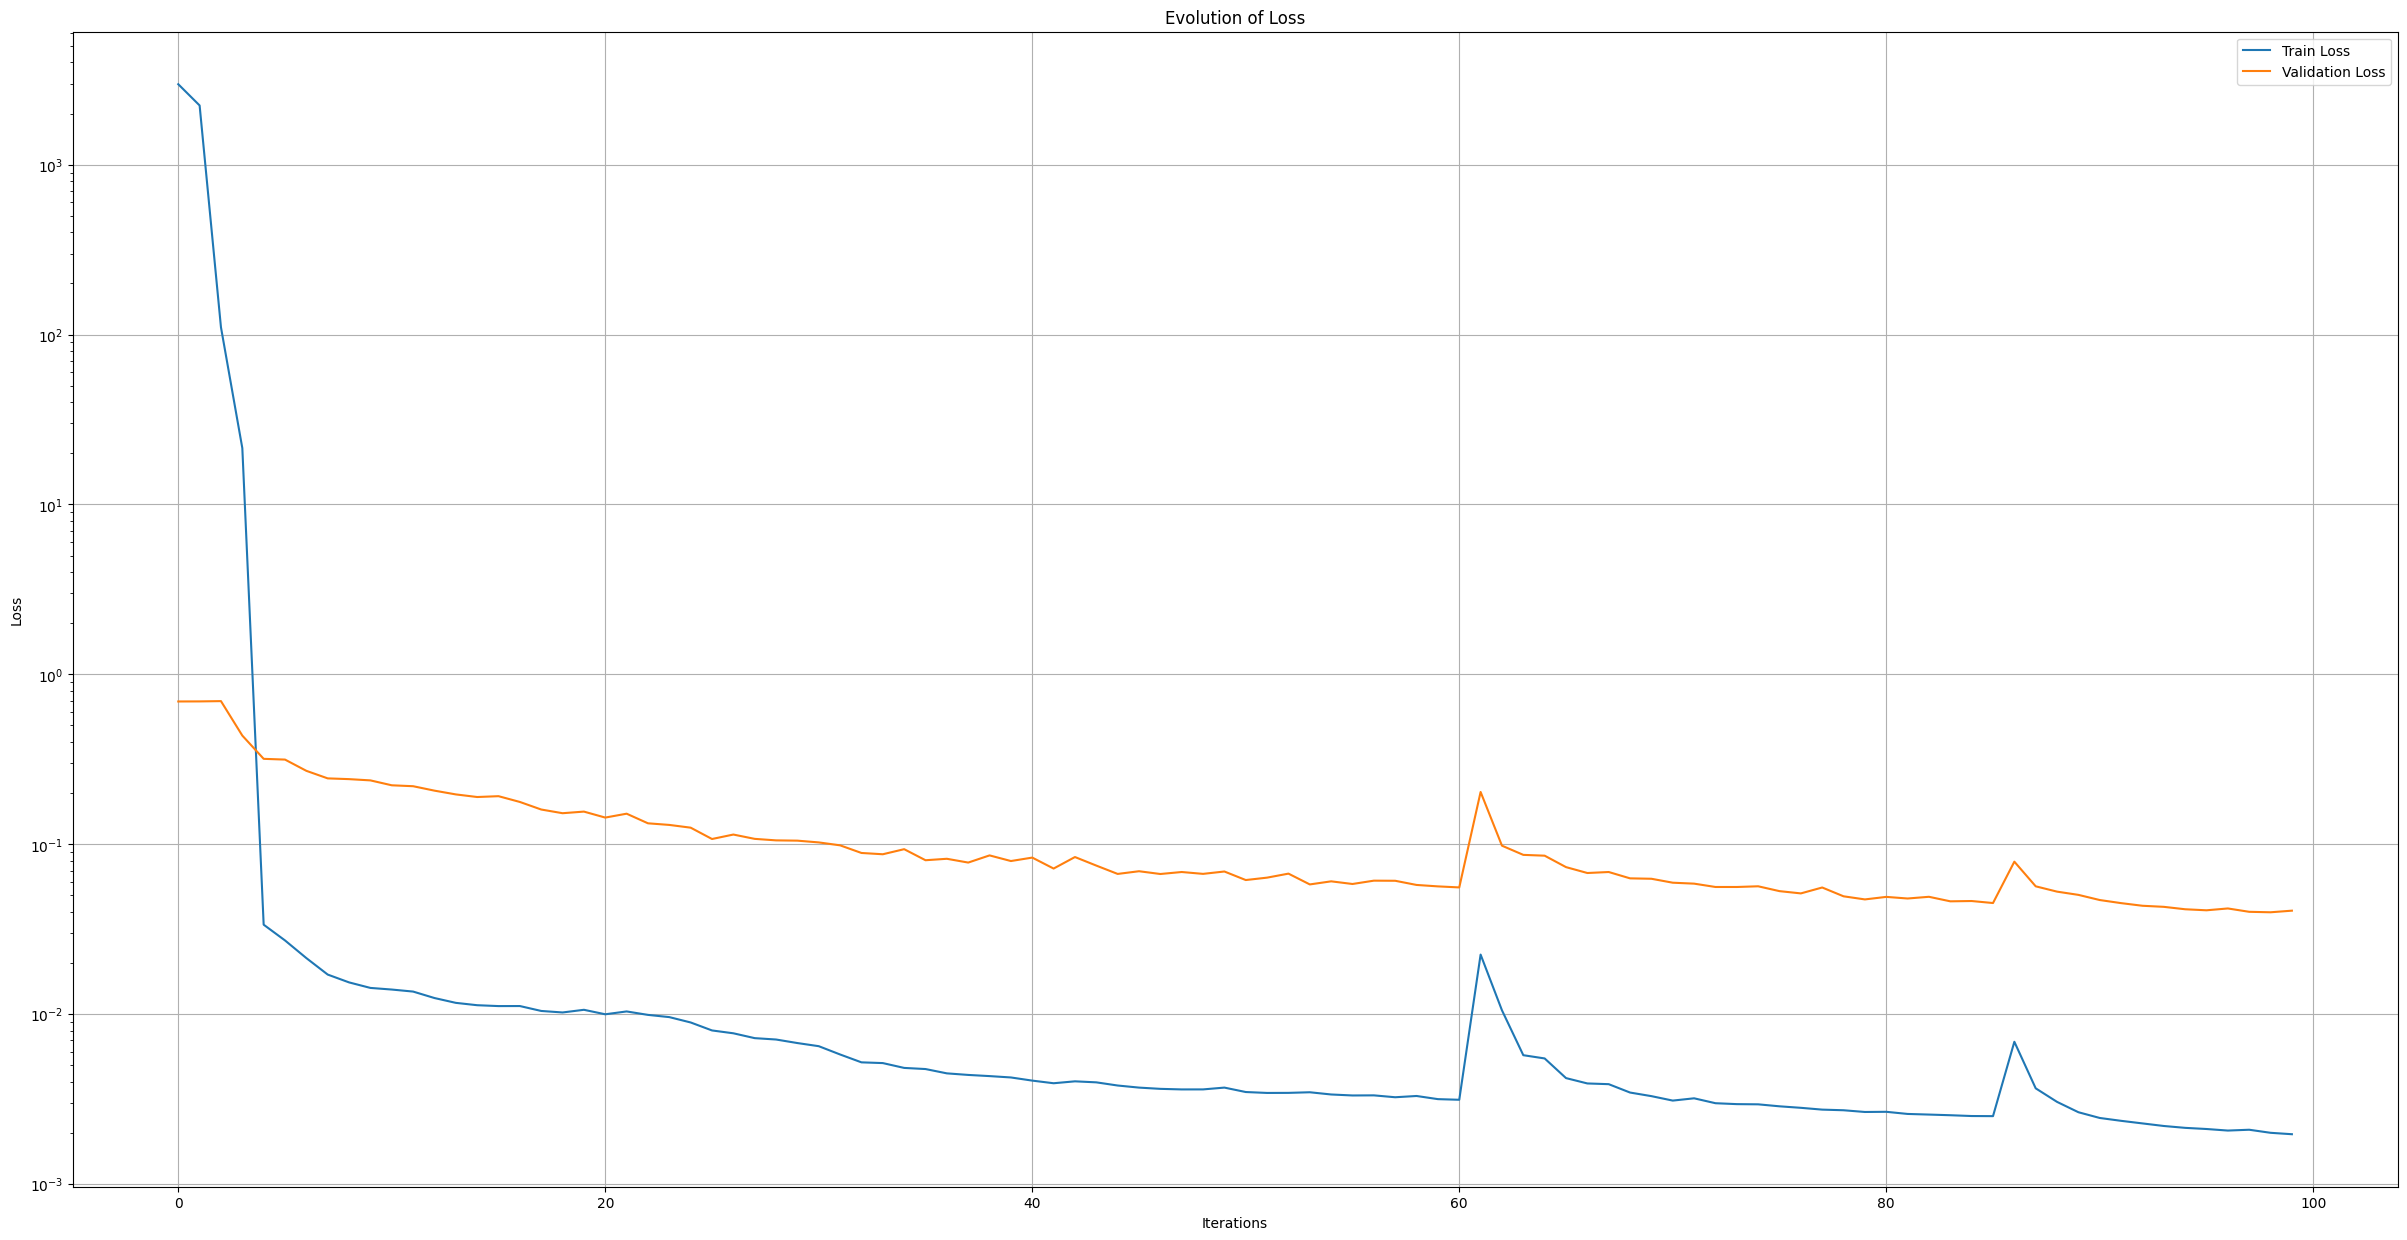

In [14]:
# Plot the training and validation losses
plot_train_val_loss(train_loss_values, val_loss_values)

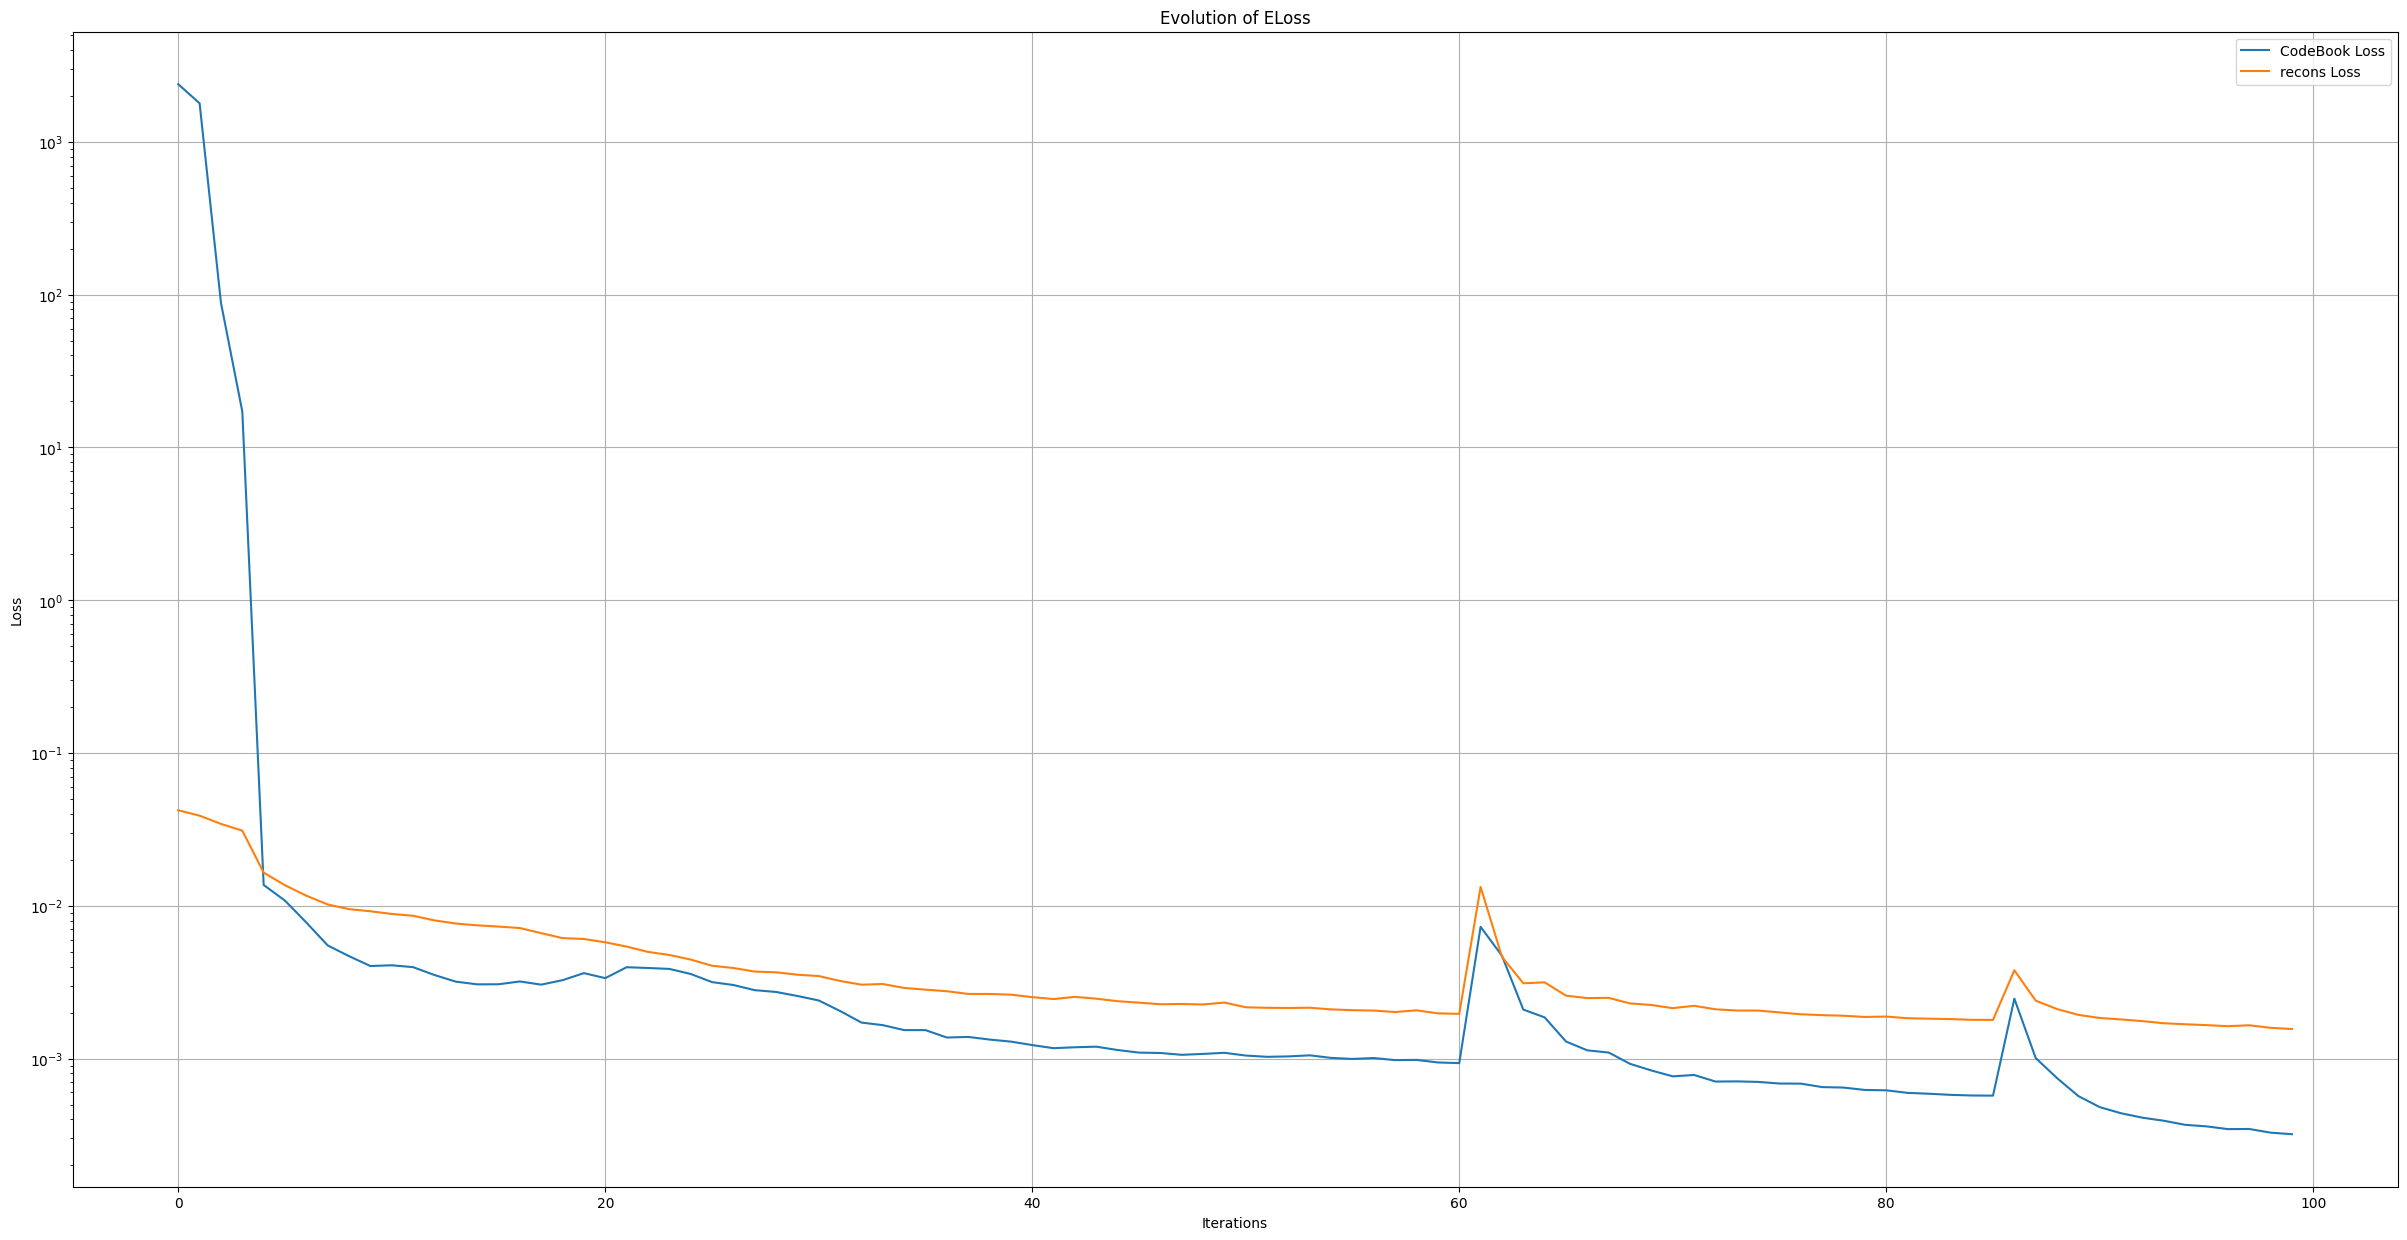

In [18]:


plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)

# recons_loss_values = np.array(train_loss_values) - ( (1+0.25)*np.array(codebook_loss_values))
# # Plot the training and validation losses
# plt.figure(figsize=(30, 15))
# # plt.plot(train_loss_values, label='Train Loss')
# # plt.plot(val_loss_values, label='Validation Loss')
# plt.plot(codebook_loss_values, label = "CodeBook Loss")
# # plt.plot(commit_loss_values, label = "Committement Loss")
# plt.plot(recons_loss_values, label = "recons Loss")
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.title('Evolution of ELoss')
# plt.legend()
# plt.grid()
# plt.show()


# Test ...

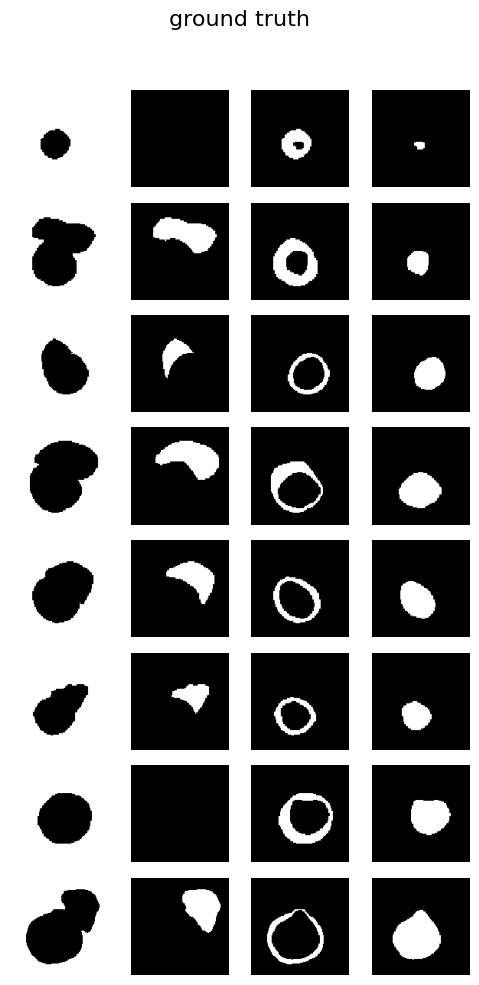

In [19]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

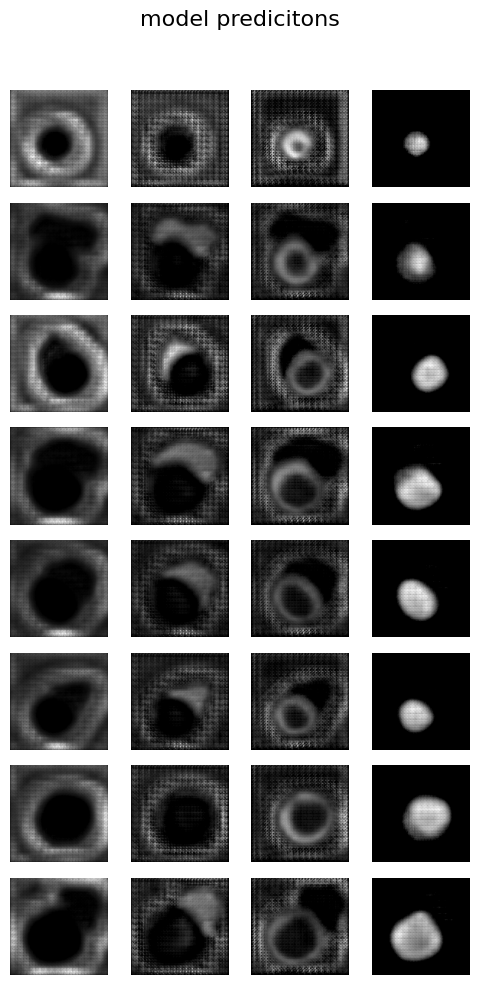

In [22]:
batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

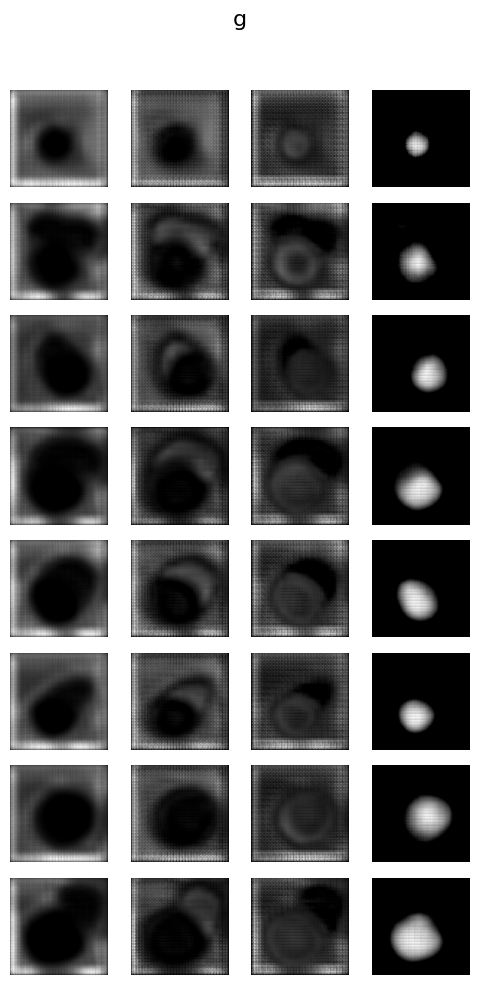

In [21]:
visualize_batch_logits(recons_evolution[-1].detach().cpu(), title = "g")